<a href="https://colab.research.google.com/github/itsjustdinesh/student-performance-analytics/blob/main/student-performance-analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn scikit-learn scipy openpyxl


STUDENT PERFORMANCE ANALYTICS SYSTEM

[Step 1/7] Generating student data...

[Step 2/7] Cleaning data...
DATA CLEANING REPORT

1. Missing Values:
Student_ID                0
Age                       0
Gender                    0
Attendance_Percent       12
Study_Hours              13
Assignments_Submitted     0
Internal_Marks            0
Final_Exam_Score          0
dtype: int64
   - Filled Attendance_Percent with median: 75.84
   - Filled Study_Hours with median: 5.14

2. Outlier Detection (IQR Method):
   - Attendance_Percent: 0 outliers detected
   - Study_Hours: 1 outliers detected
   - Final_Exam_Score: 2 outliers detected

3. Data Standardization: Complete
   - Final dataset shape: (500, 8)

✓ Cleaned data saved: 'cleaned_student_data.csv' and 'cleaned_student_data.xlsx'

[Step 3/7] Performing exploratory data analysis...

EXPLORATORY DATA ANALYSIS

1. Summary Statistics:
          Age  Attendance_Percent  Study_Hours  Assignments_Submitted  \
count  500.00              500.00 

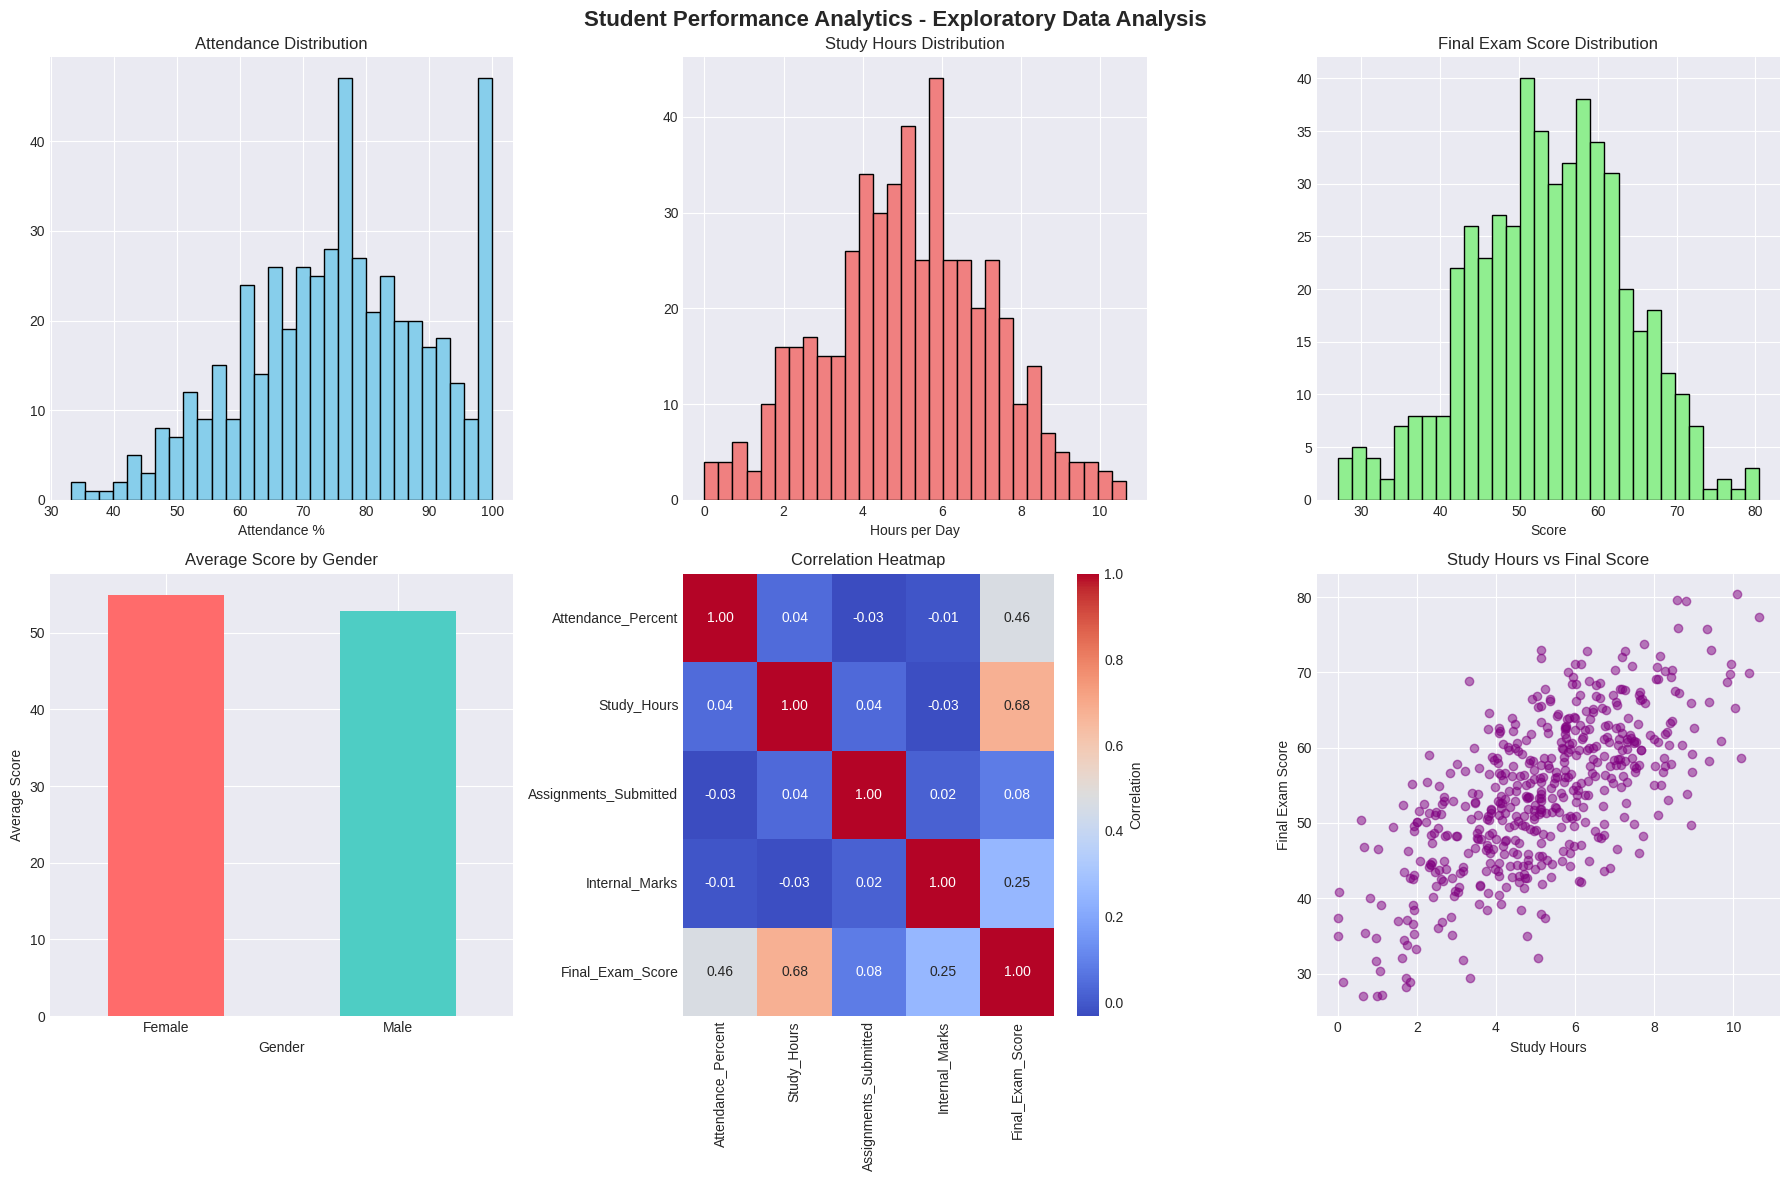


[Step 4/7] Running regression analysis...

REGRESSION ANALYSIS

1. Model Performance:
   - R² Score: 0.7325
   - Intercept: 2.13

2. Regression Coefficients:
   - Attendance_Percent: 0.2933
   - Study_Hours: 3.1743
   - Assignments_Submitted: 0.1444
   - Internal_Marks: 0.1891

   ✓ Regression plots saved as 'regression_analysis.png'


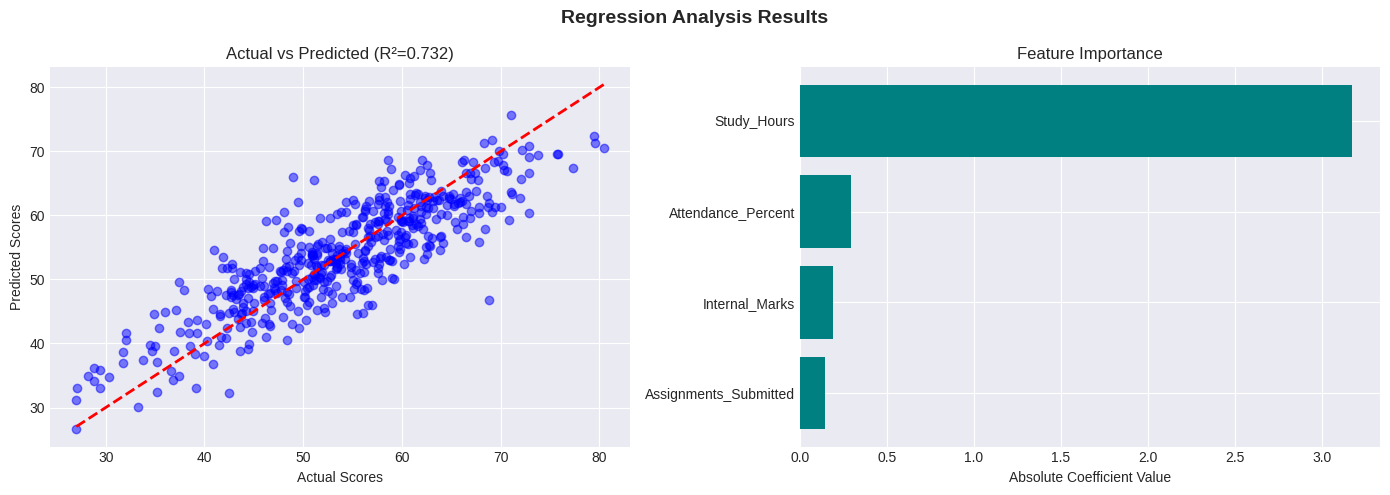


[Step 5/7] Conducting hypothesis tests...

HYPOTHESIS TESTING

1. Independent T-Test: Gender vs Final Exam Score
   H0: No difference in mean scores between genders
   H1: Significant difference exists

   Results:
   - Male Mean Score: 52.89
   - Female Mean Score: 54.96
   - T-statistic: -2.3494
   - P-value: 0.0192
   - Conclusion: REJECT H0 (significant difference, p < 0.05)

2. ANOVA Test: Study Hours Categories vs Final Exam Score
   H0: No difference in mean scores across study hour groups

   Results:
   - Low Study Hours Mean: 44.20
   - Medium Study Hours Mean: 54.51
   - High Study Hours Mean: 62.82
   - F-statistic: 138.7509
   - P-value: 0.0000
   - Conclusion: REJECT H0 (significant difference, p < 0.05)

[Step 6/7] Performing K-Means clustering...

K-MEANS CLUSTERING

1. Optimal Clusters: 3
   - Silhouette Score: 0.2888

2. Cluster Statistics:

   Low Performers (n=174):
   - Avg Attendance: 70.71%
   - Avg Study Hours: 3.10
   - Avg Final Score: 44.27

   Medium Perfor

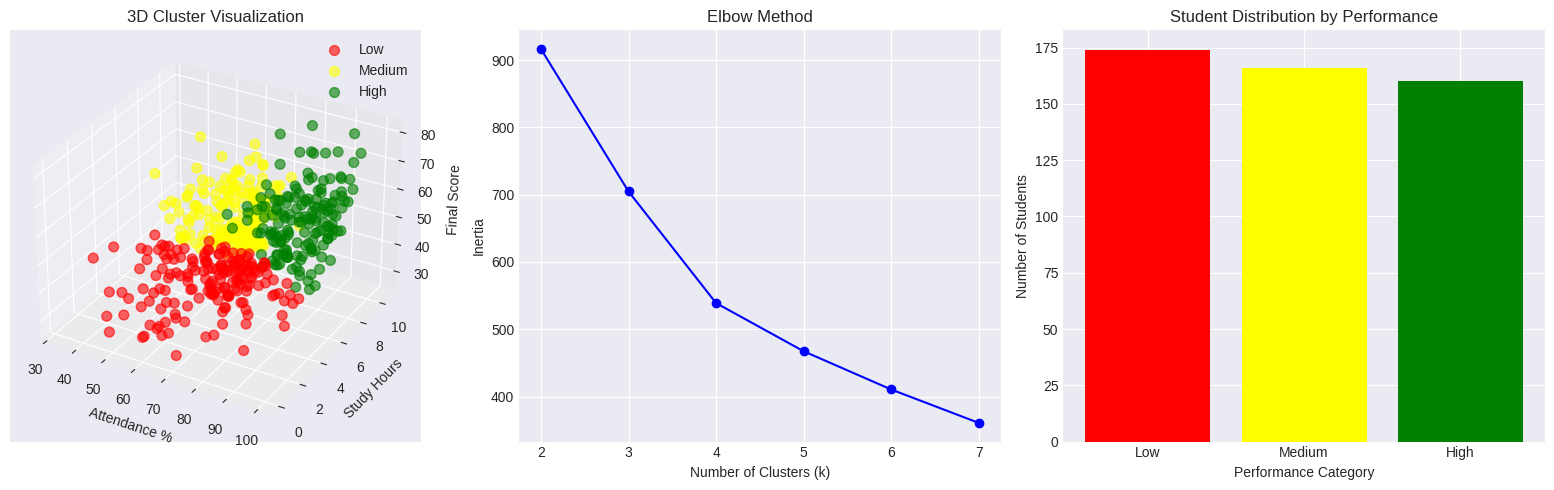


[Step 7/7] Creating dashboard...

CREATING DASHBOARD

   ✓ Dashboard saved as 'performance_dashboard.png'


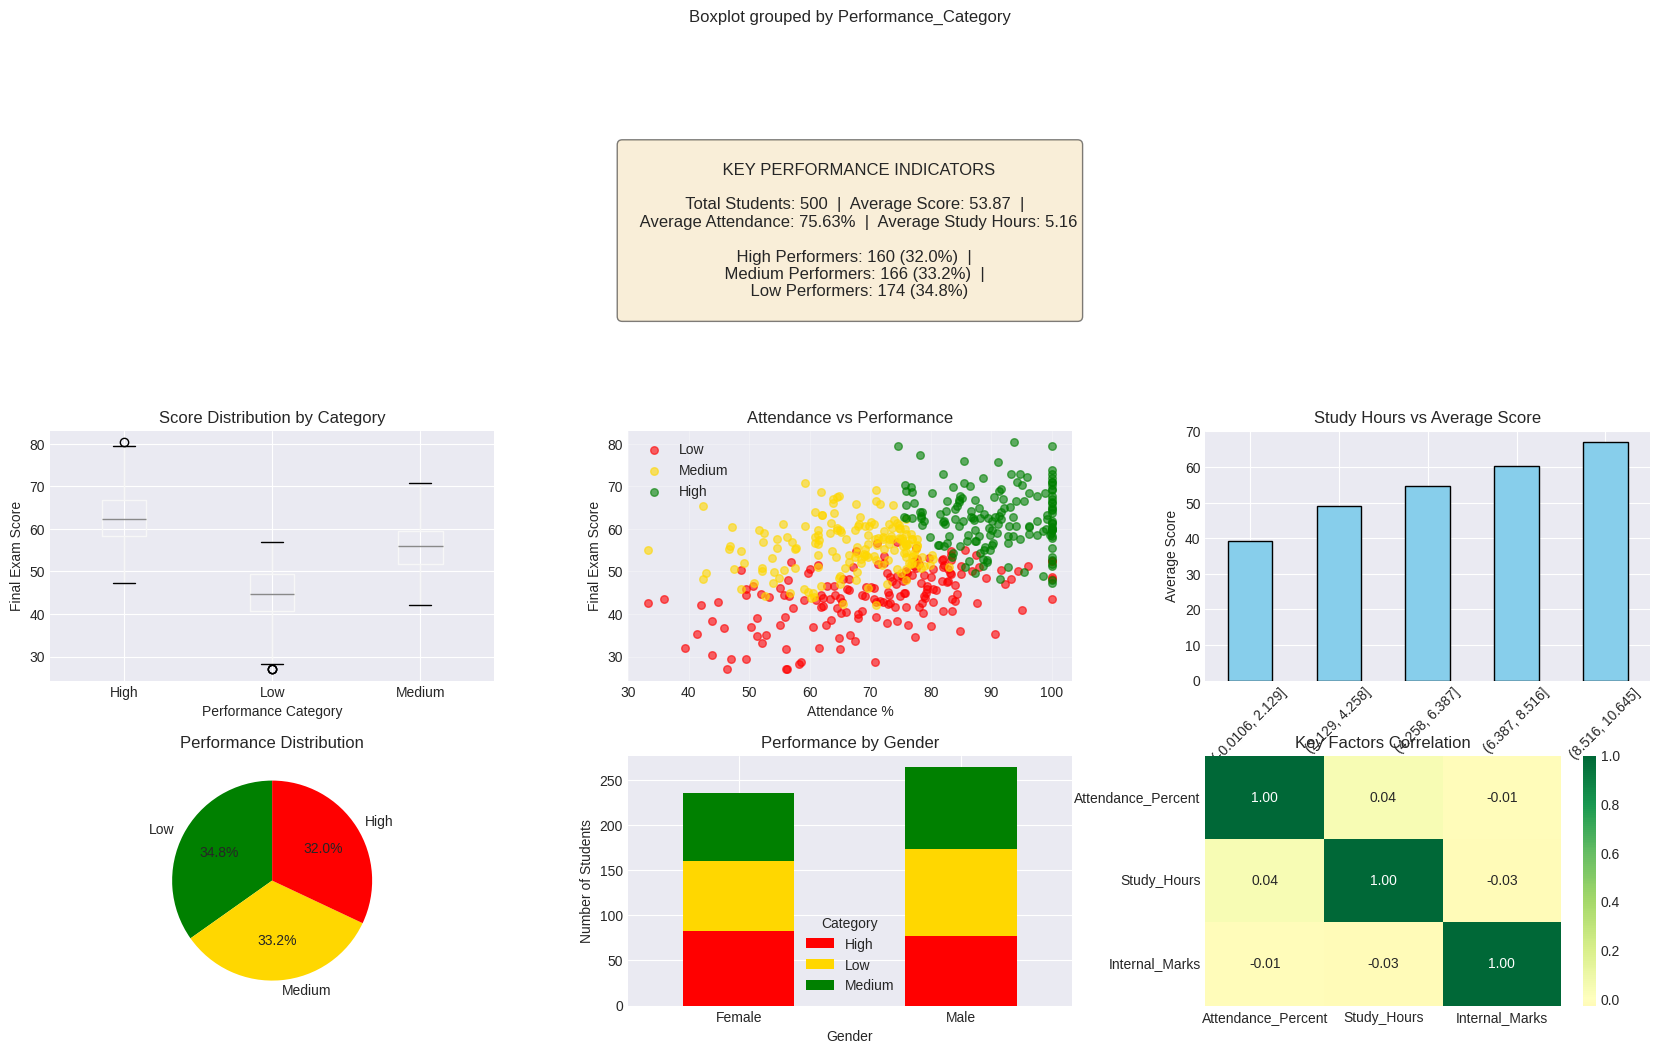


ANALYSIS COMPLETE - SUMMARY

✓ Generated Files:
   1. cleaned_student_data.csv
   2. cleaned_student_data.xlsx
   3. final_student_data_with_clusters.csv
   4. eda_analysis.png
   5. regression_analysis.png
   6. clustering_analysis.png
   7. performance_dashboard.png

✓ Key Findings:
   - Dataset: 500 students analyzed
   - Average Performance: 53.87/100
   - High Performers: 160 students
   - Statistical Tests: T-test p=0.0192, ANOVA p=0.0000

PROJECT READY FOR SUBMISSION!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, silhouette_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ==================== 1. DATA GENERATION ====================
def generate_student_data(n_students=500):
    """Generate synthetic student performance data"""
    np.random.seed(42)

    data = {
        'Student_ID': [f'STU{str(i).zfill(4)}' for i in range(1, n_students + 1)],
        'Age': np.random.randint(18, 25, n_students),
        'Gender': np.random.choice(['Male', 'Female'], n_students),
        'Attendance_Percent': np.clip(np.random.normal(75, 15, n_students), 0, 100),
        'Study_Hours': np.clip(np.random.normal(5, 2, n_students), 0, 12),
        'Assignments_Submitted': np.random.randint(5, 21, n_students),
        'Internal_Marks': np.clip(np.random.normal(60, 15, n_students), 0, 100),
        'Final_Exam_Score': None  # Will be calculated based on other factors
    }

    df = pd.DataFrame(data)

    # Generate Final Exam Score with realistic correlations
    df['Final_Exam_Score'] = (
        0.3 * df['Attendance_Percent'] +
        0.4 * df['Study_Hours'] * 8 +
        0.2 * df['Internal_Marks'] +
        0.1 * df['Assignments_Submitted'] * 2 +
        np.random.normal(0, 5, n_students)
    )
    df['Final_Exam_Score'] = np.clip(df['Final_Exam_Score'], 0, 100)

    # Add some missing values (realistic scenario)
    missing_indices = np.random.choice(df.index, size=int(0.05 * n_students), replace=False)
    df.loc[missing_indices[:len(missing_indices)//2], 'Attendance_Percent'] = np.nan
    df.loc[missing_indices[len(missing_indices)//2:], 'Study_Hours'] = np.nan

    return df

# ==================== 2. DATA CLEANING ====================
def clean_data(df):
    """Clean and preprocess the dataset"""
    print("=" * 60)
    print("DATA CLEANING REPORT")
    print("=" * 60)

    # Check for missing values
    print("\n1. Missing Values:")
    print(df.isnull().sum())

    # Fill missing values with median
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].isnull().any():
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            print(f"   - Filled {col} with median: {median_val:.2f}")

    # Detect and handle outliers using IQR method
    print("\n2. Outlier Detection (IQR Method):")
    for col in ['Attendance_Percent', 'Study_Hours', 'Final_Exam_Score']:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        print(f"   - {col}: {len(outliers)} outliers detected")

        # Cap outliers instead of removing
        df[col] = np.clip(df[col], lower_bound, upper_bound)

    print("\n3. Data Standardization: Complete")
    print(f"   - Final dataset shape: {df.shape}")

    return df

# ==================== 3. EXPLORATORY DATA ANALYSIS ====================
def exploratory_analysis(df):
    """Perform comprehensive EDA"""
    print("\n" + "=" * 60)
    print("EXPLORATORY DATA ANALYSIS")
    print("=" * 60)

    # Summary statistics
    print("\n1. Summary Statistics:")
    print(df.describe().round(2))

    # Create visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Student Performance Analytics - Exploratory Data Analysis', fontsize=16, fontweight='bold')

    # Distribution plots
    df['Attendance_Percent'].hist(bins=30, ax=axes[0, 0], color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Attendance Distribution')
    axes[0, 0].set_xlabel('Attendance %')

    df['Study_Hours'].hist(bins=30, ax=axes[0, 1], color='lightcoral', edgecolor='black')
    axes[0, 1].set_title('Study Hours Distribution')
    axes[0, 1].set_xlabel('Hours per Day')

    df['Final_Exam_Score'].hist(bins=30, ax=axes[0, 2], color='lightgreen', edgecolor='black')
    axes[0, 2].set_title('Final Exam Score Distribution')
    axes[0, 2].set_xlabel('Score')

    # Gender comparison
    gender_scores = df.groupby('Gender')['Final_Exam_Score'].mean()
    gender_scores.plot(kind='bar', ax=axes[1, 0], color=['#FF6B6B', '#4ECDC4'])
    axes[1, 0].set_title('Average Score by Gender')
    axes[1, 0].set_ylabel('Average Score')
    axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=0)

    # Correlation heatmap
    corr_cols = ['Attendance_Percent', 'Study_Hours', 'Assignments_Submitted', 'Internal_Marks', 'Final_Exam_Score']
    correlation_matrix = df[corr_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1, 1],
                cbar_kws={'label': 'Correlation'})
    axes[1, 1].set_title('Correlation Heatmap')

    # Scatter plot: Study Hours vs Final Score
    axes[1, 2].scatter(df['Study_Hours'], df['Final_Exam_Score'], alpha=0.5, c='purple')
    axes[1, 2].set_title('Study Hours vs Final Score')
    axes[1, 2].set_xlabel('Study Hours')
    axes[1, 2].set_ylabel('Final Exam Score')

    plt.tight_layout()
    plt.savefig('eda_analysis.png', dpi=300, bbox_inches='tight')
    print("\n   ✓ Visualizations saved as 'eda_analysis.png'")
    plt.show()

    return correlation_matrix

# ==================== 4. REGRESSION ANALYSIS ====================
def regression_analysis(df):
    """Perform multiple linear regression"""
    print("\n" + "=" * 60)
    print("REGRESSION ANALYSIS")
    print("=" * 60)

    # Prepare data
    X = df[['Attendance_Percent', 'Study_Hours', 'Assignments_Submitted', 'Internal_Marks']]
    y = df['Final_Exam_Score']

    # Build model
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Results
    print("\n1. Model Performance:")
    print(f"   - R² Score: {r2_score(y, y_pred):.4f}")
    print(f"   - Intercept: {model.intercept_:.2f}")

    print("\n2. Regression Coefficients:")
    for feature, coef in zip(X.columns, model.coef_):
        print(f"   - {feature}: {coef:.4f}")

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Regression Analysis Results', fontsize=14, fontweight='bold')

    # Actual vs Predicted
    axes[0].scatter(y, y_pred, alpha=0.5, color='blue')
    axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    axes[0].set_xlabel('Actual Scores')
    axes[0].set_ylabel('Predicted Scores')
    axes[0].set_title(f'Actual vs Predicted (R²={r2_score(y, y_pred):.3f})')

    # Feature importance
    importance = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': np.abs(model.coef_)
    }).sort_values('Coefficient', ascending=True)

    axes[1].barh(importance['Feature'], importance['Coefficient'], color='teal')
    axes[1].set_xlabel('Absolute Coefficient Value')
    axes[1].set_title('Feature Importance')

    plt.tight_layout()
    plt.savefig('regression_analysis.png', dpi=300, bbox_inches='tight')
    print("\n   ✓ Regression plots saved as 'regression_analysis.png'")
    plt.show()

    return model

# ==================== 5. HYPOTHESIS TESTING ====================
def hypothesis_testing(df):
    """Perform statistical hypothesis tests"""
    print("\n" + "=" * 60)
    print("HYPOTHESIS TESTING")
    print("=" * 60)

    # Test 1: Gender effect on scores (Independent T-test)
    print("\n1. Independent T-Test: Gender vs Final Exam Score")
    print("   H0: No difference in mean scores between genders")
    print("   H1: Significant difference exists")

    male_scores = df[df['Gender'] == 'Male']['Final_Exam_Score']
    female_scores = df[df['Gender'] == 'Female']['Final_Exam_Score']

    t_stat, p_value = stats.ttest_ind(male_scores, female_scores)

    print(f"\n   Results:")
    print(f"   - Male Mean Score: {male_scores.mean():.2f}")
    print(f"   - Female Mean Score: {female_scores.mean():.2f}")
    print(f"   - T-statistic: {t_stat:.4f}")
    print(f"   - P-value: {p_value:.4f}")

    if p_value < 0.05:
        print(f"   - Conclusion: REJECT H0 (significant difference, p < 0.05)")
    else:
        print(f"   - Conclusion: FAIL TO REJECT H0 (no significant difference, p ≥ 0.05)")

    # Test 2: Study hours categories (ANOVA)
    print("\n2. ANOVA Test: Study Hours Categories vs Final Exam Score")
    print("   H0: No difference in mean scores across study hour groups")

    df['Study_Category'] = pd.cut(df['Study_Hours'], bins=3, labels=['Low', 'Medium', 'High'])
    groups = [group['Final_Exam_Score'].values for name, group in df.groupby('Study_Category')]

    f_stat, p_value_anova = stats.f_oneway(*groups)

    print(f"\n   Results:")
    for category in ['Low', 'Medium', 'High']:
        mean_score = df[df['Study_Category'] == category]['Final_Exam_Score'].mean()
        print(f"   - {category} Study Hours Mean: {mean_score:.2f}")
    print(f"   - F-statistic: {f_stat:.4f}")
    print(f"   - P-value: {p_value_anova:.4f}")

    if p_value_anova < 0.05:
        print(f"   - Conclusion: REJECT H0 (significant difference, p < 0.05)")
    else:
        print(f"   - Conclusion: FAIL TO REJECT H0 (no significant difference, p ≥ 0.05)")

    return {'t_test_pvalue': p_value, 'anova_pvalue': p_value_anova}

# ==================== 6. K-MEANS CLUSTERING ====================
def kmeans_clustering(df):
    """Perform K-Means clustering to categorize student performance"""
    print("\n" + "=" * 60)
    print("K-MEANS CLUSTERING")
    print("=" * 60)

    # Select features for clustering
    features = ['Attendance_Percent', 'Study_Hours', 'Final_Exam_Score']
    X = df[features].copy()

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Find optimal number of clusters (Elbow method)
    inertias = []
    silhouette_scores = []
    K_range = range(2, 8)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

    # Use 3 clusters (Low, Medium, High performers)
    optimal_k = 3
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    df['Cluster'] = kmeans.fit_predict(X_scaled)

    # Map clusters to performance categories
    cluster_means = df.groupby('Cluster')['Final_Exam_Score'].mean().sort_values()
    cluster_mapping = {cluster_means.index[0]: 'Low',
                      cluster_means.index[1]: 'Medium',
                      cluster_means.index[2]: 'High'}
    df['Performance_Category'] = df['Cluster'].map(cluster_mapping)

    print(f"\n1. Optimal Clusters: {optimal_k}")
    print(f"   - Silhouette Score: {silhouette_score(X_scaled, df['Cluster']):.4f}")

    print("\n2. Cluster Statistics:")
    for category in ['Low', 'Medium', 'High']:
        cluster_data = df[df['Performance_Category'] == category]
        print(f"\n   {category} Performers (n={len(cluster_data)}):")
        print(f"   - Avg Attendance: {cluster_data['Attendance_Percent'].mean():.2f}%")
        print(f"   - Avg Study Hours: {cluster_data['Study_Hours'].mean():.2f}")
        print(f"   - Avg Final Score: {cluster_data['Final_Exam_Score'].mean():.2f}")

    # Visualization
    fig = plt.figure(figsize=(16, 5))

    # 3D Scatter plot
    ax1 = fig.add_subplot(131, projection='3d')
    colors = {'Low': 'red', 'Medium': 'yellow', 'High': 'green'}
    for category in ['Low', 'Medium', 'High']:
        cluster_data = df[df['Performance_Category'] == category]
        ax1.scatter(cluster_data['Attendance_Percent'],
                   cluster_data['Study_Hours'],
                   cluster_data['Final_Exam_Score'],
                   c=colors[category], label=category, alpha=0.6, s=50)
    ax1.set_xlabel('Attendance %')
    ax1.set_ylabel('Study Hours')
    ax1.set_zlabel('Final Score')
    ax1.set_title('3D Cluster Visualization')
    ax1.legend()

    # Elbow curve
    ax2 = fig.add_subplot(132)
    ax2.plot(K_range, inertias, 'bo-')
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Inertia')
    ax2.set_title('Elbow Method')
    ax2.grid(True)

    # Cluster distribution
    ax3 = fig.add_subplot(133)
    category_counts = df['Performance_Category'].value_counts()
    ax3.bar(category_counts.index, category_counts.values, color=['red', 'yellow', 'green'])
    ax3.set_xlabel('Performance Category')
    ax3.set_ylabel('Number of Students')
    ax3.set_title('Student Distribution by Performance')

    plt.tight_layout()
    plt.savefig('clustering_analysis.png', dpi=300, bbox_inches='tight')
    print("\n   ✓ Clustering plots saved as 'clustering_analysis.png'")
    plt.show()

    return df

# ==================== 7. DASHBOARD VISUALIZATION ====================
def create_dashboard(df):
    """Create comprehensive dashboard visualization"""
    print("\n" + "=" * 60)
    print("CREATING DASHBOARD")
    print("=" * 60)

    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    # Title
    fig.suptitle('Student Performance Analytics Dashboard', fontsize=20, fontweight='bold', y=0.98)

    # 1. Key Performance Indicators
    ax1 = fig.add_subplot(gs[0, :])
    ax1.axis('off')
    kpis = f"""
    KEY PERFORMANCE INDICATORS

    Total Students: {len(df)}  |  Average Score: {df['Final_Exam_Score'].mean():.2f}  |
    Average Attendance: {df['Attendance_Percent'].mean():.2f}%  |  Average Study Hours: {df['Study_Hours'].mean():.2f}

    High Performers: {len(df[df['Performance_Category']=='High'])} ({len(df[df['Performance_Category']=='High'])/len(df)*100:.1f}%)  |
    Medium Performers: {len(df[df['Performance_Category']=='Medium'])} ({len(df[df['Performance_Category']=='Medium'])/len(df)*100:.1f}%)  |
    Low Performers: {len(df[df['Performance_Category']=='Low'])} ({len(df[df['Performance_Category']=='Low'])/len(df)*100:.1f}%)
    """
    ax1.text(0.5, 0.5, kpis, ha='center', va='center', fontsize=12,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # 2. Score distribution by performance category
    ax2 = fig.add_subplot(gs[1, 0])
    df.boxplot(column='Final_Exam_Score', by='Performance_Category', ax=ax2)
    ax2.set_title('Score Distribution by Category')
    ax2.set_xlabel('Performance Category')
    ax2.set_ylabel('Final Exam Score')
    plt.sca(ax2)
    plt.xticks(rotation=0)

    # 3. Attendance vs Score scatter
    ax3 = fig.add_subplot(gs[1, 1])
    colors_map = {'Low': 'red', 'Medium': 'gold', 'High': 'green'}
    for category in ['Low', 'Medium', 'High']:
        data = df[df['Performance_Category'] == category]
        ax3.scatter(data['Attendance_Percent'], data['Final_Exam_Score'],
                   c=colors_map[category], label=category, alpha=0.6, s=30)
    ax3.set_xlabel('Attendance %')
    ax3.set_ylabel('Final Exam Score')
    ax3.set_title('Attendance vs Performance')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Study hours impact
    ax4 = fig.add_subplot(gs[1, 2])
    study_bins = pd.cut(df['Study_Hours'], bins=5)
    study_performance = df.groupby(study_bins)['Final_Exam_Score'].mean()
    study_performance.plot(kind='bar', ax=ax4, color='skyblue', edgecolor='black')
    ax4.set_title('Study Hours vs Average Score')
    ax4.set_xlabel('Study Hours Range')
    ax4.set_ylabel('Average Score')
    ax4.tick_params(axis='x', rotation=45)

    # 5. Performance category pie chart
    ax5 = fig.add_subplot(gs[2, 0])
    category_counts = df['Performance_Category'].value_counts()
    ax5.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
            colors=['green', 'gold', 'red'], startangle=90)
    ax5.set_title('Performance Distribution')

    # 6. Gender comparison
    ax6 = fig.add_subplot(gs[2, 1])
    gender_perf = df.groupby(['Gender', 'Performance_Category']).size().unstack(fill_value=0)
    gender_perf.plot(kind='bar', ax=ax6, stacked=True, color=['red', 'gold', 'green'])
    ax6.set_title('Performance by Gender')
    ax6.set_xlabel('Gender')
    ax6.set_ylabel('Number of Students')
    ax6.legend(title='Category')
    ax6.tick_params(axis='x', rotation=0)

    # 7. Top factors correlation
    ax7 = fig.add_subplot(gs[2, 2])
    top_factors = df[['Attendance_Percent', 'Study_Hours', 'Internal_Marks']].corr()
    sns.heatmap(top_factors, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax7, center=0)
    ax7.set_title('Key Factors Correlation')

    plt.savefig('performance_dashboard.png', dpi=300, bbox_inches='tight')
    print("\n   ✓ Dashboard saved as 'performance_dashboard.png'")
    plt.show()

# ==================== 8. MAIN EXECUTION ====================
def main():
    """Main execution function"""
    print("\n" + "=" * 60)
    print("STUDENT PERFORMANCE ANALYTICS SYSTEM")
    print("=" * 60)

    # Generate data
    print("\n[Step 1/7] Generating student data...")
    df = generate_student_data(n_students=500)

    # Clean data
    print("\n[Step 2/7] Cleaning data...")
    df_clean = clean_data(df.copy())

    # Save cleaned data
    df_clean.to_csv('cleaned_student_data.csv', index=False)
    df_clean.to_excel('cleaned_student_data.xlsx', index=False)
    print("\n✓ Cleaned data saved: 'cleaned_student_data.csv' and 'cleaned_student_data.xlsx'")

    # EDA
    print("\n[Step 3/7] Performing exploratory data analysis...")
    correlation_matrix = exploratory_analysis(df_clean)

    # Regression
    print("\n[Step 4/7] Running regression analysis...")
    model = regression_analysis(df_clean)

    # Hypothesis testing
    print("\n[Step 5/7] Conducting hypothesis tests...")
    test_results = hypothesis_testing(df_clean)

    # Clustering
    print("\n[Step 6/7] Performing K-Means clustering...")
    df_final = kmeans_clustering(df_clean)

    # Dashboard
    print("\n[Step 7/7] Creating dashboard...")
    create_dashboard(df_final)

    # Save final dataset with clusters
    df_final.to_csv('final_student_data_with_clusters.csv', index=False)

    # Summary report
    print("\n" + "=" * 60)
    print("ANALYSIS COMPLETE - SUMMARY")
    print("=" * 60)
    print("\n✓ Generated Files:")
    print("   1. cleaned_student_data.csv")
    print("   2. cleaned_student_data.xlsx")
    print("   3. final_student_data_with_clusters.csv")
    print("   4. eda_analysis.png")
    print("   5. regression_analysis.png")
    print("   6. clustering_analysis.png")
    print("   7. performance_dashboard.png")

    print("\n✓ Key Findings:")
    print(f"   - Dataset: {len(df_final)} students analyzed")
    print(f"   - Average Performance: {df_final['Final_Exam_Score'].mean():.2f}/100")
    print(f"   - High Performers: {len(df_final[df_final['Performance_Category']=='High'])} students")
    print(f"   - Statistical Tests: T-test p={test_results['t_test_pvalue']:.4f}, ANOVA p={test_results['anova_pvalue']:.4f}")

    print("\n" + "=" * 60)
    print("PROJECT READY FOR SUBMISSION!")
    print("=" * 60)

# Run the complete analysis
if __name__ == "__main__":
    main()